# **Drive Mount and Dataset Unzip**

**HEALTH CARE**

Predicting pneumonia from chest X-ray images

Dataset link: https://www.kaggle.com/tolgadincer/labeled-chest-xray-images

Google Drive link: https://drive.google.com/file/d/1xYceBz1JMSD4TDNQMQ2yMDYbe4oHZTIt/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip updated dataset from drive, with labelled test data
!mkdir dataset
%cd dataset
!unzip "/content/drive/MyDrive/archive.zip"
%cd ..

# **Common Cells for both Models**
**CONSTANTS, Helper Functions, Imports, Optimizer, Data Generator, Class Weights,Test Data Load**

**CONSTANTS**

In [ ]:
input_shape = (150,150,3)
target_size = (150,150)
epochs = 50
batch_size = 64
patience = 3
classes = ('normal', 'pneumonia')
train_dir = './dataset/chest_xray/train'
test_dir = './dataset/chest_xray/test'

**Helper Functions**

In [ ]:
def plot_model_accuracy(H):
  plt.plot(H.history['accuracy'])
  plt.plot(H.history['val_accuracy'])
  plt.title('Model Auccary')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left', bbox_to_anchor=(1,1))
  plt.show()

def plot_model_loss(H):
  plt.plot(H.history['loss'])
  plt.plot(H.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train Loss', 'Validation Loss'], loc='upper left', bbox_to_anchor=(1,1))
  plt.show()

def plot_model_lr(H):
  N = np.arange(0, len(H.epoch))
  plt.style.use('ggplot')
  plt.figure()
  plt.plot(N, H.history['accuracy'], label='train_accuracy')
  plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
  plt.plot(N, H.history['loss'], label='train_loss')
  plt.plot(N, H.history['val_loss'], label='val_loss')
  plt.title('Training loss and accuracy')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss/Accuracy')
  plt.legend()
  plt.show()

def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, target_size)  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

def one_hot_encoding(pred):
  ohe = [0] * len(pred) # Equal to categories (i.e. 2)
  index = 0
  for i in range(len(pred)):
    if (pred[i] > pred[index]):
      index = i
  ohe[index] = 1
  return ohe

def get_title(pred, actual):
  if((pred == classes[0] and actual[0] == 1) or (pred == classes[1] and actual[1] == 1)):
    return pred + '(✓)'
  else:
    return pred + '(✕)'

**Import Required Libraries**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow
from imutils import paths
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

**SGD Optimizer (With Exponential Decay)**

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

**Data Generator (Train, Validation, Test)**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

**Flow from Directory (Train, Validation & Test)**

In [ ]:
train_dataset = train_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = target_size,
                                                  class_mode = 'categorical',
                                                  subset = 'training',
                                                  batch_size = batch_size)

valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = target_size,
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = batch_size)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                target_size = target_size,
                                                class_mode = 'categorical',
                                                batch_size = batch_size)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Evaluate Class Weights (To handle data imbalance)**

In [ ]:
train_class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_dataset.classes), 
            train_dataset.classes)

class_weights = { 0: train_class_weights[0], 1: train_class_weights[1] }
print('Class weights (imblanced classes):', class_weights)

Class weights (imblanced classes): {0: 1.938425925925926, 1: 0.6738010943031864}


**Load Test Data**

In [ ]:
print('Loading test images:')
X_test, y_test = load_data(test_dir)

  3%|▎         | 6/234 [00:00<00:04, 50.42it/s]

Loading test images:


100%|██████████| 390/390 [00:02<00:00, 146.21it/s]


**Test Labels to One Hot Encoding**

In [ ]:
lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)
y_test = np.hstack((1 - y_test, y_test))

# **Resnet50 (Base Model)**

**Resnet50 imagenet**

In [ ]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

**Freezing Layers**

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

**Defining Layers**

In [ ]:
model_base=Sequential()
model_base.add(base_model)
model_base.add(GlobalAveragePooling2D())
model_base.add(Dense(64, activation='relu'))
model_base.add(Dropout(0.3))
model_base.add(Dense(2,activation='softmax'))

**Model Summary**

In [ ]:
model_base.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_132 (None, 2048)              0         
_________________________________________________________________
dense_278 (Dense)            (None, 64)                131136    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_279 (Dense)            (None, 2)                 130       
Total params: 23,718,978
Trainable params: 131,266
Non-trainable params: 23,587,712
_________________________________________________________________


**Model Compile with SGD Optimzer**

In [ ]:
model_base.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

**Defining Callbacks**

In [ ]:
filepath = './best_base_weights.hdf5'

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max', 
                              patience = patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max',
                                save_best_only=True, 
                                verbose = 1)

callback_list = [early_stopping, checkpoint]

**Model Fitting**

In [ ]:
H_base = model_base.fit(train_dataset,
              validation_data=valid_dataset,
              epochs = epochs,
              callbacks = callback_list,
              class_weight = class_weights,
              verbose = 1)

Epoch 1/50
66/66 [==============================] - 53s 772ms/step - loss: 0.7648 - accuracy: 0.4847 - val_loss: 0.6941 - val_accuracy: 0.4325

Epoch 00001: val_accuracy improved from -inf to 0.43254, saving model to ./best_base_weights.hdf5
Epoch 2/50
66/66 [==============================] - 50s 752ms/step - loss: 0.6924 - accuracy: 0.4798 - val_loss: 0.6980 - val_accuracy: 0.2574

Epoch 00002: val_accuracy did not improve from 0.43254
Epoch 3/50
66/66 [==============================] - 49s 749ms/step - loss: 0.6926 - accuracy: 0.4645 - val_loss: 0.6770 - val_accuracy: 0.7426

Epoch 00003: val_accuracy improved from 0.43254 to 0.74258, saving model to ./best_base_weights.hdf5
Epoch 4/50
66/66 [==============================] - 50s 751ms/step - loss: 0.6884 - accuracy: 0.5729 - val_loss: 0.6878 - val_accuracy: 0.7569

Epoch 00004: val_accuracy improved from 0.74258 to 0.75694, saving model to ./best_base_weights.hdf5
Epoch 5/50
66/66 [==============================] - 50s 755ms/step - 

**Load Base Model Weights (if required)**

In [ ]:
model_base.load_weights("best_base_weights.hdf5")

# **Resnet50 (Summary)**
**Test Loss/Accuracy, Training/Validation Graphs, Confusion Matrix, Classification Report & Visual Results**

**Evaluating Loss and AUC - Test Data**

In [ ]:
score = model_base.evaluate(test_dataset)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

10/10 [==============================] - 6s 588ms/step - loss: 0.6780 - accuracy: 0.7244
Test Loss:  0.6780446767807007
Test Accuracy:  0.7243589758872986


**Summarize Model Loss**

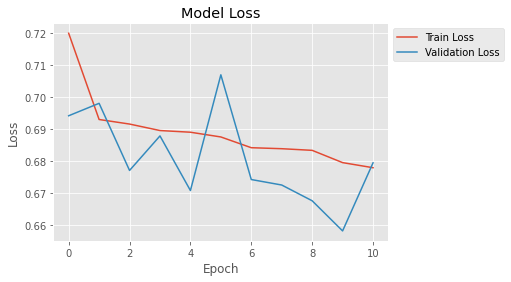

In [ ]:
plot_model_loss(H_base)

**Summarize Model Accuracy**

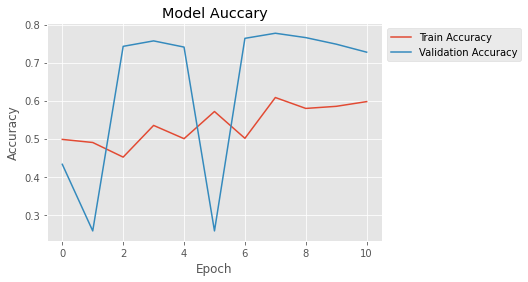

In [ ]:
plot_model_accuracy(H_base)

**Summarize Learning Curve (Accuracy and Loss)**

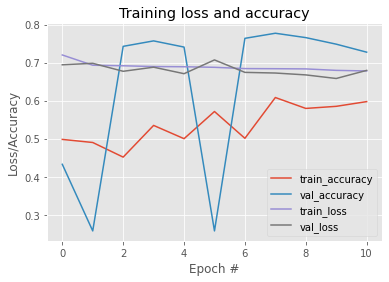

In [ ]:
plot_model_lr(H_base)

**CONFUSION MATRIX**

In [ ]:
# Making prediction
y_pred = model_base.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[ 85, 149],
       [ 22, 368]])

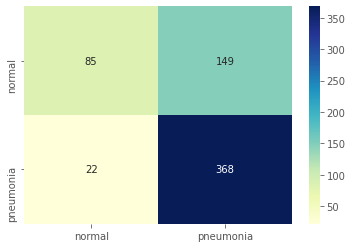

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='d', cmap="YlGnBu")

**Classification Report (Precision, Recall, F1-score, Support)**

In [ ]:
from sklearn.metrics import classification_report
predictions = model_base.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

      normal       0.79      0.36      0.50       234
   pneumonia       0.71      0.94      0.81       390

    accuracy                           0.73       624
   macro avg       0.75      0.65      0.66       624
weighted avg       0.74      0.73      0.69       624



**Visual Results**

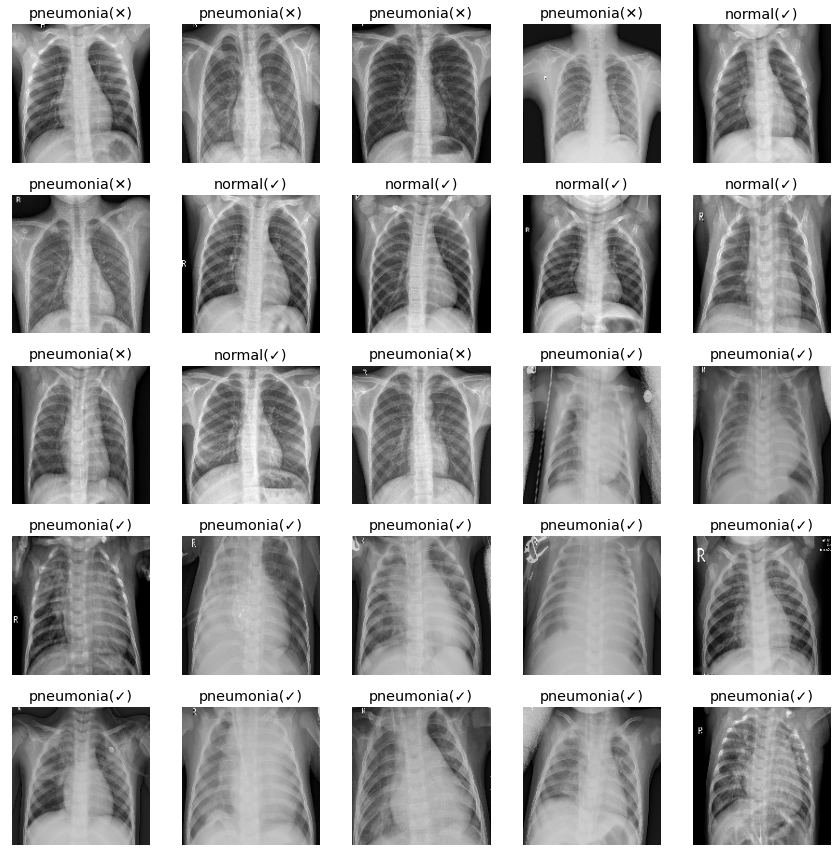

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12,12))
num=0
for i in range(5):
    for j in range(5):
        img = X_test[num]
        ax[i][j].imshow(img)
        ohe = one_hot_encoding(y_pred[num])
        ax[i][j].set_title(get_title(classes[ohe.index(1)], y_test[num]))
        num += 18
        
ax[0][0].set_yticks([])
ax[0][0].set_xticks([])
plt.tight_layout()
plt.show()

# **Resnet50 + Attention based Module (Enhanced Model)**

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  net = cbam_block(net)
  return net

def cbam_block(cbam_feature, ratio=8):	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


def channel_attention(input_feature, ratio=8):
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [ ]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, attention_module='cbam_block'):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                
            y = attach_attention_module(y, attention_module)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

**Resnet 50 + CBAM (Enhanced Model)**

In [ ]:
# For ResNet, specify the depth (e.g. ResNet50: depth=50)
depth = 50
model_enhanced = resnet_v1(input_shape=input_shape, depth=depth, attention_module='cbam_block')

**Model Summary**

In [ ]:
model_enhanced.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1050 (Conv2D)            (None, 150, 150, 16) 448         input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_727 (BatchN (None, 150, 150, 16) 64          conv2d_1050[0][0]                
__________________________________________________________________________________________________
activation_1041 (Activation)    (None, 150, 150, 16) 0           batch_normalization_727[0][0]    
___________________________________________________________________________________________

**Model Compile with SGD Optimizer**

In [ ]:
model_enhanced.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'accuracy')],
              optimizer=optimizer)

**Data Augmentation (Training Data)**

In [ ]:
train_augmented = ImageDataGenerator(rescale = 1.0 / 255.0,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    channel_shift_range=0.2,
                                    fill_mode='nearest',
                                    horizontal_flip=False,
                                    validation_split = 0.2)

**Flow form Directory (Training & Validation Data)**

In [ ]:
train_augmented_dataset = train_augmented.flow_from_directory(directory = train_dir,
                                                              target_size = target_size,
                                                              class_mode = 'categorical',
                                                              subset = 'training',
                                                              batch_size = batch_size)

Found 4187 images belonging to 2 classes.


**Defining Callbacks**

In [ ]:
filepath = './best_enhanced_weights.hdf5'

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max', 
                              patience = patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [early_stopping, checkpoint]

In [ ]:
# Fit the model on the batches generated by datagen.flow().
H_enhanced = model_enhanced.fit(train_augmented_dataset,
                                validation_data=valid_dataset,
                                class_weight = class_weights,
                                epochs=epochs,
                                verbose=1,
                                callbacks=callback_list)

Epoch 1/50
66/66 [==============================] - 116s 2s/step - loss: 1.0176 - accuracy: 0.7680 - val_loss: 1.0940 - val_accuracy: 0.5596

Epoch 00001: val_accuracy improved from -inf to 0.55956, saving model to ./best_enhanced_weights.hdf5
Epoch 2/50
66/66 [==============================] - 98s 1s/step - loss: 0.7820 - accuracy: 0.8856 - val_loss: 0.9551 - val_accuracy: 0.7996

Epoch 00002: val_accuracy improved from 0.55956 to 0.79963, saving model to ./best_enhanced_weights.hdf5
Epoch 3/50
66/66 [==============================] - 99s 1s/step - loss: 0.7573 - accuracy: 0.9036 - val_loss: 1.0167 - val_accuracy: 0.8603

Epoch 00003: val_accuracy improved from 0.79963 to 0.86033, saving model to ./best_enhanced_weights.hdf5
Epoch 4/50
66/66 [==============================] - 99s 1s/step - loss: 0.7468 - accuracy: 0.9037 - val_loss: 1.0716 - val_accuracy: 0.8408

Epoch 00004: val_accuracy did not improve from 0.86033
Epoch 5/50
66/66 [==============================] - 99s 1s/step - lo

**Load Enhanced Model Weights (if required)**

In [ ]:
model_enhanced.load_weights("best_enhanced_weights.hdf5")

# **Resnet50 + Attention based Module (Summary)**
**Test Loss/Accuracy, Training/Validation Graphs, Confusion Matrix, Classification Report & Visual Results**

**Evaluating Loss and AUC - Test Data**

In [ ]:
score = model_enhanced.evaluate(test_dataset)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

10/10 [==============================] - 7s 633ms/step - loss: 0.6687 - accuracy: 0.9432
Test Loss:  0.6687048673629761
Test Accuracy:  0.9431834816932678


**Summarize Model Loss**

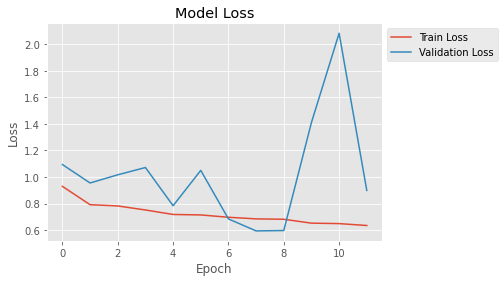

In [ ]:
plot_model_loss(H_enhanced)

**Summarie Model Accuracy**

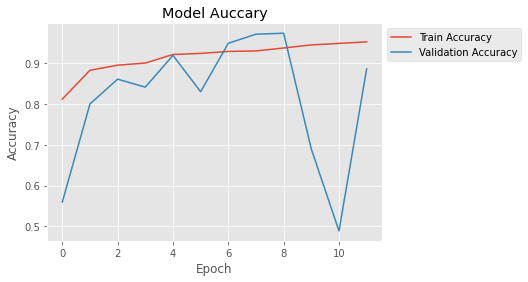

In [ ]:
plot_model_accuracy(H_enhanced)

**Summarize Learning Curve (Accuracy and Loss)**

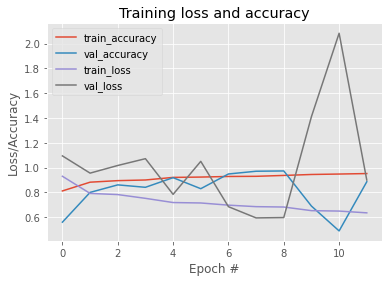

In [ ]:
plot_model_lr(H_enhanced)

**CONFUSION MATRIX**

In [ ]:
# Making prediction
y_pred_enhanced = model_enhanced.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred_enhanced, axis=1))
confusion_mtx

array([[177,  57],
       [ 12, 378]])

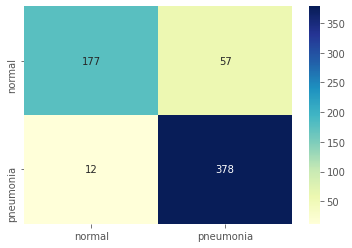

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='d', cmap="YlGnBu")

**Classification Report (Precision, Recall, F1-score, Support)**

In [ ]:
from sklearn.metrics import classification_report
predictions = model_enhanced.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

      normal       0.94      0.76      0.84       234
   pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.89      0.89      0.89       624



**Visual Results**

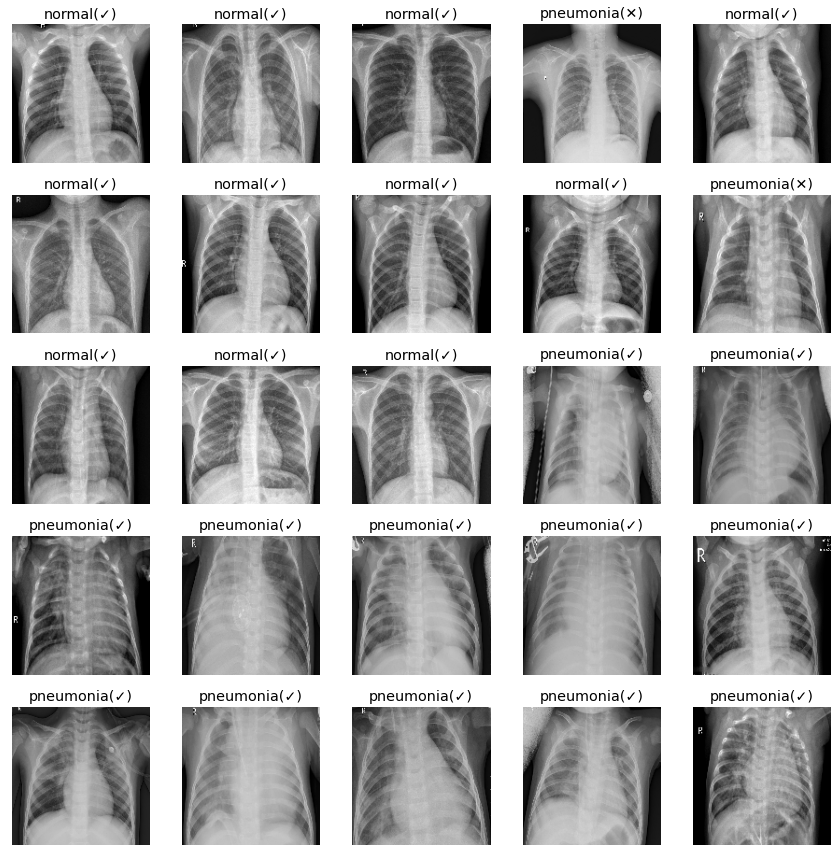

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12,12))
num=0
for i in range(5):
    for j in range(5):
        img = X_test[num]
        ax[i][j].imshow(img)
        ohe = one_hot_encoding(y_pred_enhanced[num])
        ax[i][j].set_title(get_title(classes[ohe.index(1)], y_test[num]))
        num += 18
        
ax[0][0].set_yticks([])
ax[0][0].set_xticks([])
plt.tight_layout()
plt.show()